In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import skimage
import skimage.color
from skimage import morphology

In [2]:
# Logarithmic distance from one color to the other
def DistanceFromColor(color1, color2):
    c1_hsv = skimage.color.rgb2hsv(color1.reshape(1,1,3))
    c2_hsv = skimage.color.rgb2hsv(color2.reshape(1,1,3))

    dist = np.linalg.norm(c1_hsv - c2_hsv)
    return dist

# Get objects and  their properties from b&w image
def GetProperties(img):
    # Labels
    imlabel1 = skimage.measure.label(img, background=0)
    labs = np.unique(imlabel1)

    # Get descriptors   
    props = skimage.measure.regionprops(imlabel1, intensity_image=img)
    return props

In [3]:
# Process one frame from video, frame - full colored frame, mask - movement mask
def ProcessFrame(mask, frame):    
    position = [-1, -1]

    props = GetProperties(mask)
    # print("Found objects ", len(props))
    
    obj_list = []
    pixbox = (0, 0, frame.shape[0], frame.shape[1])

    # Go through detected objects
    for i in range(0, len(props)): 
        object_number = i
        ci = props[object_number].convex_image

        # TODO there will probably be "long" movement objects and the tip is small, so we will need to do this differently!!        
    	# Go through pixels in bounding box
        count = 0
        bbox = props[object_number].bbox

        if (bbox == pixbox):
            continue

        # These are relevant
        # print("bounding box ", props[object_number].bbox)
        # print("centroid ", props[object_number].centroid)
        # print("label ", props[object_number].label)
        # plt.imshow(ci)
        # plt.show()

        for x in range(bbox[0], bbox[2]):
            for y in range(bbox[1], bbox[3]):
                # Count how many red ones
                # TODO pretty sure colour is in BGR
                dist = DistanceFromColor(frame[x, y], np.array([0, 0, 1]))
                # TODO threshold decided experimentally
                if (dist <= 0.6):
                    count += 1
    
        # If enough say that it is an object and add it to the list
        if (count/(float)((bbox[2]-bbox[0])*(bbox[3]-bbox[1])) > 0.5):
            # print("Is a tool!")
            obj_list.append(props[object_number])

    
    # TODO keeps just ONE object
    # TODO could be optimized into previous loop
    # go through detected tools and if any are too close together, join them ??
    # add a mark to every object in image (at centroid)
    for i in range(0, len(obj_list)):
        for j in range(-10, 10):
            position[0] = obj_list[i].centroid[0]
            position[1] = obj_list[i].centroid[1]

    return position

In [4]:
# Mark object at position in frame
# Returns edited frame 
def MarkObjects(frame, position):
    newImage = frame.copy()
    
    for j in range(-10, 10):
        x = (int)(position[1][0])
        y = (int)(position[1][1])

        newImage[x+j,y] = (0, 0, 0)
        newImage[x,y+j] = (0, 0, 0)
        newImage[x+j+1,y+1] = (0, 0, 0)
        newImage[x+1,y+j+1] = (0, 0, 0)
        newImage[x+j-1,y-1] = (0, 0, 0)
        newImage[x-1,y+j-1] = (0, 0, 0)

    return newImage

In [12]:
def InterpolatePositions(positions):
    newPositions = []

    # TODO how to deal with empty first frames
    for i in range(0, positions[0][0]):
        newPos = [i, [0,0]]
        newPositions.append(newPos)

    newPositions.append(positions[0])

    for i in range(1, len(positions)):
        # frame index
        index2 = positions[i][0]
        index1 = positions[i-1][0]

        # distance in time 
        diff = index2 - index1
        if (diff == 1):
            newPositions.append(positions[i])
            continue

        # linear interpolation time

        # step
        stepX = (positions[i][1][0] - positions[i-1][1][0]) / diff
        stepY = (positions[i][1][1] - positions[i-1][1][1]) / diff

        # create new frames
        for j in range(1, diff):
            position = [0, 0]
            position[0] = positions[i-1][1][0] + j * stepX
            position[1] = positions[i-1][1][1] + j * stepY
            newPos = [index1 + j, position]
            newPositions.append(newPos)

        newPositions.append(positions[i])

    return newPositions

In [6]:
# Get frames with detected motiion using MOG2 operator, returns list of segmented frames
def GetFrames(path):
    frames = []
    masks = []

    cap = cv.VideoCapture(path)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    fgbg = cv.createBackgroundSubtractorMOG2()
    while(1):
        ret, frame = cap.read()
        if ret == False:
            break

        # Find moving objects in image -> returns a mask
        fgmask = fgbg.apply(frame)
        fgmask = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel)

        # Mask out background
        moving_objects = cv.bitwise_and(frame, frame, mask=fgmask)

        frames.append(frame)
        masks.append(fgmask)
        cv.imshow('frame', moving_objects)
        k = cv.waitKey(30) & 0xff
    cap.release()
    cv.destroyAllWindows()

    return [frames, masks]

In [7]:
def ProcessVideo(frames, masks):
    processed = []
    positions = []
    print("Starting processing...")

    # go through all frames
    for i in range(0, len(frames)):
        frame = frames[i]
        mask = masks[i]
        mask = mask > 0.5

        # TODO filter empty frames!!!
        pos = ProcessFrame(mask, frame)

        if not (pos[0] == -1 and pos[1] == -1):
            positions.append([i, pos])

    # interpolate
    positions = InterpolatePositions(positions)

    print("p: ", len(positions), " f: ", len(frames))

    # draw
    for i in range(0, len(positions)):
        frameIndex = positions[i][0] # i
        frame = frames[frameIndex]
        
        outimg = MarkObjects(frame, positions[i])
        processed.append(outimg)

    height, width, layers = frame.shape
    size = (width,height)
    
    print("Saving video...")
    # write a video
    out = cv.VideoWriter('outTest.avi', cv.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(processed)):
        out.write(processed[i])
    
    out.release()

In [8]:
[frames, masks] = GetFrames('test.mp4')
print(len(frames))

340


In [11]:
# TODO works for ONE OBJECT ONLY right now
ProcessVideo(frames, masks)
print("Outputted a video")

Starting processing...
l1:  305
p:  340  f:  340
0   0
1   1
2   2
3   3
4   4
5   5
6   6
7   7
8   8
9   9
10   10
11   11
12   12
13   13
14   14
15   15
16   16
17   17
18   18
19   19
20   20
21   21
22   22
23   23
24   24
25   25
26   26
27   27
28   28
29   29
30   30
31   31
32   32
33   33
34   34
35   35
36   36
37   37
38   38
39   39
40   40
41   41
42   42
43   43
44   44
45   45
46   46
47   47
48   48
49   49
50   50
51   51
52   52
53   53
54   54
55   55
56   56
57   57
58   58
59   59
60   60
61   61
62   62
63   63
64   64
65   65
66   66
67   67
68   68
69   69
70   70
71   71
72   72
73   73
74   74
75   75
76   76
77   77
78   78
79   79
80   80
81   81
82   82
83   83
84   84
85   85
86   86
87   87
88   88
89   89
90   90
91   91
92   92
93   93
94   94
95   95
96   96
97   97
98   98
99   99
100   100
101   101
102   102
103   103
104   104
105   105
106   106
107   107
108   108
109   109
110   110
111   111
112   112
113   113
114   114
115   115
116   116
1

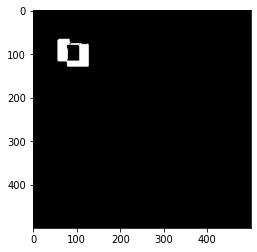

Found objects  1
(0, 500, 0, 500)
bounding box  (66, 56, 130, 128)
centroid  (99.56079917326903, 91.21563899414399)
label  1


Drawing 


In [69]:
# Detect objects from camera
img = masks[30]
frame = frames[30]
img = img > 0.5
plt.imshow(img, cmap='gray')
plt.show()

outimg = ProcessFrame(img, frame)
plt.imshow(outimg)
plt.show()

This should be a parser that doesnt want to exist right now

In [4]:
%pylab inline
import skimage
from skimage.io import imread
import cv2
from pathlib import Path
import pandas as pd
pd.__version__

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


'1.4.2'

In [6]:
# idk what this does, cant test it, god help me install packages.

import pickle
import xml.etree.ElementTree as ET
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
source_width = 512
source_height = 512

# TODO tohle bych exportoval do skriptu zvlášť a pak to tady jenom loadnul
# TODO asi nepotřebujeme parsovat images, jenom to xml? nevim jak vypadá vevnitř formát
# TODO udělat z toho list kde bude vždycky key = frame number a pak data asociovaný s tim (label, x, y)

# Path to annotations + data
tree = ET.parse('data/dataset_1/segmentation_dataset/annotations.xml')
photo_dir ="data/dataset_1/segmentation_dataset/images/"
root = tree.getroot()
mask_lst = []
image_lst = []
for i in root:
    if i.tag=="image":
        img = tf.keras.preprocessing.image.load_img(photo_dir + i.attrib['name'] + ".PNG", target_size=(source_width, source_height))

        image_lst.append(tf.keras.preprocessing.image.img_to_array(img))
        width = int(i.attrib['width'])
        height = int(i.attrib['height'])
        Rx = source_width/width
        Ry = source_height/height
        mask = np.zeros((source_width,source_height),dtype=np.uint8)

        for img in i:
            if img.attrib['label'] == "needle holder":
                needle_holder_point = img.attrib['points']
                point = [float(k) for k in needle_holder_point.split(',')]
                point = [Rx*point[0],Ry*point[1]]
                round_up = [math.ceil(num) for num in point]
                round_down = [math.floor(num) for num in point]
                mask[round_up[0],round_up[1]] = 1
                mask[round_up[0], round_down[1]] = 1
                mask[round_down[0], round_up[1]] = 1
                mask[round_down[0], round_down[1]] = 1


            if img.attrib['label'] == "scissors":
                scissors_point = img.attrib['points']
                point = [float(k) for k in scissors_point.split(',')]
                point = [Rx * point[0], Ry * point[1]]
                round_up = [math.ceil(num) for num in point]
                round_down = [math.floor(num) for num in point]
                mask[round_up[0], round_up[1]] = 2
                mask[round_up[0], round_down[1]] = 2
                mask[round_down[0], round_up[1]] = 2
                mask[round_down[0], round_down[1]] = 2

            if img.attrib['label'] == "tweezers":
                tweezers = img.attrib['points']
                point = [float(k) for k in tweezers.split(',')]
                point = [Rx * point[0], Ry * point[1]]
                round_up = [math.ceil(num) for num in point]
                round_down = [math.floor(num) for num in point]
                mask[round_up[0], round_up[1]] = 3
                mask[round_up[0], round_down[1]] = 3
                mask[round_down[0], round_up[1]] = 3
                mask[round_down[0], round_down[1]] = 3
        mask_lst.append(mask.transpose())

ModuleNotFoundError: No module named 'tensorflow'

# Optical Flow Demo:

In [12]:
import numpy as np
import cv2 as cv
import argparse
parser = argparse.ArgumentParser(description='This sample demonstrates Lucas-Kanade Optical Flow calculation. \
                                              The example file can be downloaded from: \
                                              https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4')
# parser.add_argument('image', type=str, help='path to image file')
# args = parser.parse_args()
cap = cv.VideoCapture('kitty.mp4')
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)
    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
cv.destroyAllWindows()

No frames grabbed!
